## Isolation Forest (iForest)
* Unsupervised Decision Tree - Proximity-Based Approach.
* An outlier should be the observation that is easier isolated.
* Fast and do not consume memory since it does not use any distance measure to detect anomalies.
* Suitable for large datasets.
* Instead of finding a "normal" distribution and then checking if an observation falls inside, it spots outliers directly.
* Anomalies will be data points first to be singled out, and normal data points will fall deep into the tree.

<img src="../figures/iforest.png">


### Prepare a data set

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils_od import count_stat, confusion_matrix, confusion_matrix_threshold,plot_data ,descriptive_stat_threshold 
from pyod.utils.data import generate_data


contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997
1,1.631040,1.746182,1.898050,2.380148,1.967332,1.858916
2,1.824683,2.131412,2.028829,1.703454,2.502966,2.119108
3,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661
4,1.829647,1.775596,1.829438,2.054768,1.577190,1.594549


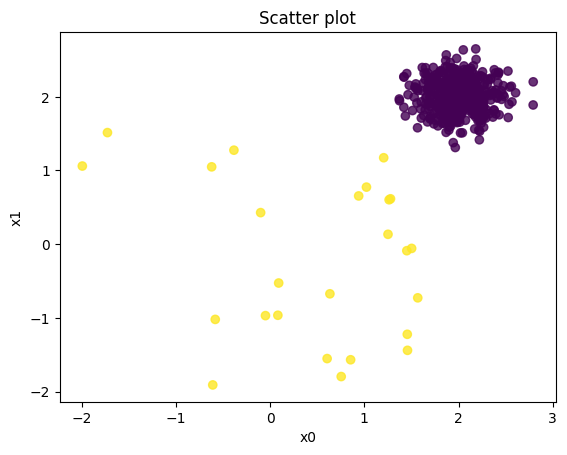

In [3]:
plot_data(X_train_pd, y_train)

### Build the model
* Each iTree is a binary tree, where each node in the tree has exactly 0 or 2 daughter nodes, it grows until a condition is met.
* Conditions:
- - The end node has only one data point.
- - all data in a node has the same values.
- - tree reaches the height limit set.
*
* iTree's do not need to be fully developed until the end.
* Forest, in order to avoid overfitting, it builds many iTrees and averages the predictions of the trees.
*
* How does it work:
1. It randomly samples observations ( from which also takes a random number of its features ). Every instance will appear in at least 1 sample.
2. iTree is build per sample, outputing an outlier score.
3. Therefore, an instance can end up having as many outlier scores as iTrees ( if appeared in all iTrees )
4. iForest computes the arithmetic mean of the scores to get the final score.

In [5]:
from pyod.models.iforest import IForest
isft = IForest(contamination=0.05, max_samples=40, behaviour='new') 
isft.fit(X_train)

# Training data
y_train_scores = isft.decision_function(X_train)
y_train_pred = isft.predict(X_train)

# Test data
y_test_scores = isft.decision_function(X_test)
y_test_pred = isft.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined contanimation rate
print("The threshold for the defined contamination rate:" , isft.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: -5.85122228446977e-15
The training data: {0: 475, 1: 25}
The training data: {0: 474, 1: 26}


#### Understand the parameters

* max_samples: Number of observations ( tables ) retrieved from data set to run each estimator. This is the size of each iTree.
* n_estimators: Amount of iTrees in the ensemble.
* max_features: Number of features to retrieve from data set to run each estimator.
* n_jobs: Number of jobs to be run in parallel for fit and predict. (if -1, num jobs = num cores.)

In [7]:
isft.get_params()

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.05,
 'max_features': 1.0,
 'max_samples': 40,
 'n_estimators': 100,
 'n_jobs': 1,
 'random_state': None,
 'verbose': 0}

### Feature Importance
* Since its a tree approach, we can check the Gini Impurity Index.
* It tells us the importance of features in determining outliers.
* Values sum up to 1.

In [8]:
isft_vi = isft.feature_importances_
print(
    f"Features importance: {isft_vi}\nsum up to {sum(isft_vi)}"
    )

Features importance: [0.18859191 0.16842162 0.17905395 0.15529902 0.14048066 0.16815284]
sum up to 1.0


### Plot feature importance

<Axes: >

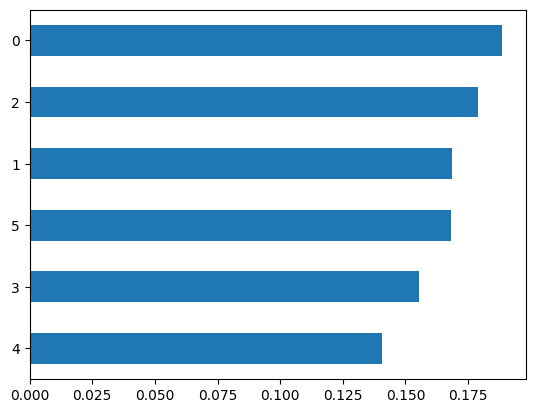

In [9]:
from matplotlib import pyplot as plt
for_plot = pd.DataFrame({'x_axis':X_train_pd.columns, 'y_axis':isft_vi}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

Feature 0 seems to explain better why observation are outliers or not, compared to feature 4.

### Determine the threshold
* To understand which is the better threshold that splits a data observation to be considered normal or an outlier, we can check the Outlier Scores.
* By plotting a histogram of the outliers scores, we can appreciate that the best threshold seems to be: around 0.0.

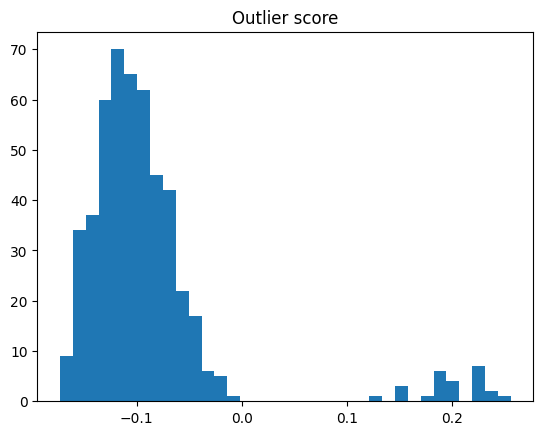

In [10]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### Descriptive statistics
* Even though the histogram looks very nice, we need to ensure that statistically it makes sense. Which means checking the Soundness of the model.
* This tables allow us to asses the model outcome.
*
* Count %: Size of outlier group. It should be around 5% since we created the data set. In a real-world scenario we need to understand the context of the data. Also, a higher threshold will decrease the amount of outliers.
* Features mean: Should be consistent with prior knowledge of data. If any feature shows counter-intuitive result, should be further examined or removed.
* Average Anomaly Score: Should be far higher in the anomaly group than in the normal one.


In [13]:
threshold = isft.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.1
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,0.2


In [14]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,474,94.8,2.02,2.01,2.01,1.99,2.01,2.00,-0.10
1,Outlier,26,5.2,0.10,-0.42,-0.15,0.03,0.01,0.21,0.19


In [15]:
confusion_matrix_threshold(y_train,y_train_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Aggregate Model Predictions to Achieve Stability
1. Standarize the input data in case the features do not share the same scale.
2. Play with different hyperparameters: Amount ff iTrees for example.
3. Store predicted scores per model.
4. Aggregate results to balance for overfitting or other model issues.


In [16]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.iforest import IForest

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of maximum samples 
k_list = [20, 30, 40, 50, 60]
k_list = [100, 200, 300, 400, 500]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    #isft = IForest(contamination=0.05, max_samples=k) 
    isft = IForest(contamination=0.05, n_estimators=k) 
    isft.fit(X_train_norm)
    
    # Store the results in each column:
    train_scores[:, i] = isft.decision_function(X_train_norm) 
    test_scores[:, i] = isft.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

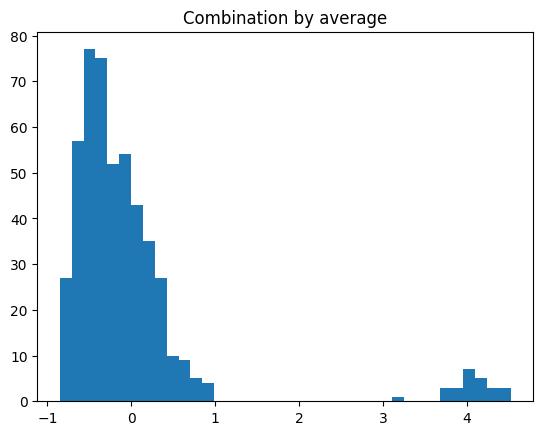

In [17]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

As we can see, the mean outlier score between the models is ploted above. This tells us that the best threshold value ( the value that better splits the outlier group from the normal group ) should be around 1.
* But let's support this statement statistically.
- - If the difference in anomaly score between the normal group and anomaly group is higher than before, will indicate that the threshold splits the groups in a better way.

In [23]:
averaged_threshold = 1.0
descriptive_stat_threshold(X_train,y_train_by_average, averaged_threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.21
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,4.05


In [24]:
descriptive_stat_threshold(X_test,y_test_by_average, averaged_threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,472,94.4,2.01,2.01,2.01,1.99,2.01,2.00,-0.2
1,Outlier,28,5.6,0.24,-0.26,0.02,0.17,0.17,0.33,3.8


## Summary iForest
* IForest directly and explicityl isolates anomalies without profiling the normal distribution of a variable.
* It adopts a tree structure to isolate every single instance. Anomalies are the instances first to be singled out, whereas normal instances tend to cluster together amid the tree.
* Since it does not use any distance approach to detect anomalies, it is fast and suitable for large data sets and high dimensional problems.
